In [62]:
# Author: Shaurya Pathak; Registration Number: 200187620
# Last Edited: 17-05-2023

# Prologue: SARSA Algorithm, for more information please read the prologue to the Q-Learning algorithm which was created before this

# Importing all the necessary libraries, and calling the environment with the name env 

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *

size_board = 4
env=Chess_Env(size_board)

In [63]:
# Initialising the game by calling the Initialise game function from within the environment
# This function creates a new board with none of the ally or enemy pieces interacting with one another
# S displays the board, X is the initial input to the neural network, i.e. features of the game, and allowed_a 
# are the allowed actions in this position

S,X,allowed_a=env.Initialise_game()


In [64]:
# Creating a simple function for Epsilon Decay, this was done just to to keep the ratio of decay to episodes constant
# while testing

def e_decay(epsilon, all_episodes, episode_number):

    # My own custom beta parameter, came to this one while tweaking all hyper parameters

    epsilon = epsilon
    all_episodes = all_episodes
    episode_number = episode_number
    
    beta = 9/all_episodes

    decayed_epsilon = (epsilon / (1 + beta * episode_number))  
    return decayed_epsilon

# Now making a simple function to initialise our weights and biases

def init_wt_b(input_size, output_size, hidden_size):

    # Keeping it in the function, also using code from lab 3
    i = input_size
    h = hidden_size
    o = output_size

    W1 = np.random.uniform(0,1,(h, i))
    W2 = np.random.uniform(0,1,(o, h))

    # The following normalises the random weights so that the sum of each row =1
    W1 = np.divide(W1,np.matlib.repmat(np.sum(W1,1)[:,None],1,i))
    W2 = np.divide(W2,np.matlib.repmat(np.sum(W2,1)[:,None],1,h))

    B1 = np.zeros((h,))
    B2 = np.zeros((o,))

    return W1, W2, B1, B2

# Defining a feedforward function for our algorithm

def feedforward(input, w1, w2, b1, b2):

    # Simple feedforward method, sourced from lab 3 of course 
    # On another note, I have tried using different activation functions but for some reason sigmoid tends to provide the performance
    # I also understand the fact that this is not a classification problem and hence an activation function from hidden to output is not required
    # However, for some unknown reason removing this reduces performance

    h1 = np.matmul(w1,input) + b1
    ha = 1/(1+np.exp(-h1))
    h2 = np.matmul(w2, ha) + b2
    action_qvals = 1/(1+np.exp(-h2))
    return action_qvals, ha

# Defining a backpropagation function for our algorithm

def backpropagate_and_update(error, current_q_vals, current_hidden_layer_q_vals, current_input, W1, W2, B1, B2, dW1, dW2, dB1, dB2, learning_rate):

    # This is also borrowed from lab 3
    
    x2 = current_q_vals
    ha = current_hidden_layer_q_vals
    X = current_input
    eta = learning_rate
    # Backpropagation: output layer -> hidden layer
    delta2 = x2*(1-x2) * error

    dW2 = np.outer(delta2, ha)
    dB2 = delta2

    # Backpropagation: hidden layer -> input layer
    delta1 = ha*(1-ha) * np.dot(W2.T, delta2)
    dW1 = np.outer(delta1,X)
    dB1 = delta1

    # After each batch update the weights using accumulated gradients
    W2 += eta*dW2
    W1 += eta*dW1

    B1 += eta*dB1
    B2 += eta*dB2

    return W1, W2, B1, B2

# Defining our Epsilon Greedy function

def policy(decayed_epsilon, allowed_actions, action_probabilities):

    # E-Greedy implementation which takes into account the decayed epsilon value

    if np.random.rand() < decayed_epsilon:

        # Explores, using the pre-coded random agent provided

        a,_ = np.where(allowed_actions==1)
        action = np.random.permutation(a)[0]

    else:

        # This for some reason took a long time to implement, but this basically parses the allowed_a input and then sets everything apart 
        # from the values which are allowed to zero and then the argmax function parses the index with the highest q-value and returns the action
        # I could have just indexed from allowed actions twice instead but I realised that later

        allowed_actions_squeezed = np.squeeze(allowed_actions)
        selectable_actions = np.where(allowed_actions_squeezed == 1, action_probabilities, 0)
        action = np.argmax(selectable_actions)

    return action

In [83]:
# There was a random agent here before, for comparison but to save time I'll just add the random agents outputs instead
# Random Agent: 

# Rewards: ~0.2
# Average Number of Moves: ~10-40

In [66]:
# Initialising our environment 

S,X,allowed_a=env.Initialise_game()

# Initialising our Neural Network 

output_size =np.shape(allowed_a)[0]   # All possible actions
input_size = np.shape(X)[0]           # Input Size, X
hidden_size = 200                     # Number of Hidden Nodes

W1, W2, B1, B2 = init_wt_b(input_size,output_size,hidden_size) # Obtaining the weights and biases from our weights function

# Defining our hyperparameters, tuned slightly differently from the suggested parameters but these worked better

epsilon_0 = 0.3                # Starting value for our Epsilon
discount_factor = 0.5          # gamma
learning_rate = 0.0035         # eta
num_episodes = 100000          # the number of games that are going to be played

In [67]:
# Keeping track of rewards and moves taken to compare to the random agent

r_save = np.zeros([num_episodes, 1])
n_moves_save = np.zeros([num_episodes, 1])


In [68]:
# Starting our training loop, this is the SARSA implementation of the problem


for n in range(num_episodes):

    epsilon_f = e_decay(epsilon_0, num_episodes, n)   # Decaying Epsilon

    Done=0                                   # While loop init

    i = 1                                    # Setting/Resetting the counter for number of moves

    S,X,allowed_a=env.Initialise_game()      # Initialiing our game once again

    episode_reward = 0                       # Setting/Resetting the episode reward
    
    # Initialising the deltas for our episode

    dW1 = np.zeros(W1.shape)
    dW2 = np.zeros(W2.shape)

    dB1 = np.zeros(B1.shape)
    dB2 = np.zeros(B2.shape)

    # Firing neurons to get probabilities for action, i.e. q values; also getting the q values of the hidden layer from the feedwforward method so that life is less complicated later

    action_probs,hidden_layer_q_vals = feedforward(X,W1,W2,B1,B2)
        
    # Selecting the action that has the highest probability

    action = policy(epsilon_f, allowed_a, action_probs)

    while not Done:                           # Starting episode

        # Applying our selected action to the board and getting the next state back

        next_S, next_X ,allowed_a_next,R, Done =env.OneStep(action)

        # Computing our rewards
        episode_reward += R

        if Done == 1:   # In this case the episode is complete and since the environment does not produce a next action/state we can say that the current q value can be used as next q value 

            # Selecting the action Q values for both current and next, and also for better readability of code, no one wants to see action_probs anywhere else (very naughty variable)

            current_action_q_vals = np.squeeze(action_probs)
            next_action_q_vals = np.squeeze(action_probs)

            # Computing our temporal difference target, we don't need to do the epsilon greedy trouble in the done case since the next state is the current state

            td_target_q_vals = np.copy(current_action_q_vals)
            td_target_q_vals[action,] = episode_reward

            # Now we compute the error by calculating the difference between our target and actual value
            
            td_error = td_target_q_vals - current_action_q_vals

            W1, W2, B1, B2 = backpropagate_and_update(td_error, current_action_q_vals, hidden_layer_q_vals, action, W1, W2, B1, B2, dW1, dW2, dB1, dB2, learning_rate)

            # Saving valuable information

            r_save[n] = episode_reward
            n_moves_save[n] = i

            break     
        # The episode is not over
        else:
            lilbro = 1

        # Now we will compute the error to ready for back propagation
        # To start we feedforward the next state

        next_action_probs,_ = feedforward(next_X,W1,W2,B1,B2)

        # Selecting the action Q values for both current and next, and also for better readability of code, no one wants to see action_probs anywhere else

        current_action_q_vals = np.squeeze(action_probs)
        next_action_q_vals = np.squeeze(next_action_probs)

        # Also have to take next action for SARSA by using the same policy

        next_action = policy(epsilon_f, allowed_a_next, next_action_probs)

        # Computing our temporal difference target

        td_target_q_vals = np.copy(current_action_q_vals)
        td_target_q_vals[action,] = episode_reward + discount_factor * next_action_q_vals[next_action,]

        # Now we compute the error by calculating the difference between our target and actual value
        
        td_error = td_target_q_vals - current_action_q_vals

        W1, W2, B1, B2 = backpropagate_and_update(td_error, current_action_q_vals, hidden_layer_q_vals, action, W1, W2, B1, B2, dW1, dW2, dB1, dB2, learning_rate)
        
        # Converting next state to be the current state to feed into the neural network again  
        S=np.copy(next_S)
        X=np.copy(next_X)
        allowed_a=np.copy(allowed_a_next)
        action = np.copy(next_action)
        action_probs = np.copy(next_action_probs)
        
        # Updating the number of moves
        
        i += 1



In [84]:
print("LILBRO's Performance on SARSA\n\nAverage reward: ", np.mean(r_save), "\nNumber of moves: ", np.mean(n_moves_save))

LILBRO's Performance on SARSA

Average reward:  0.61983 
Number of moves:  10.974


In [70]:
# Dirty code to plot the results, also plotting only the last 10000 steps so that the noise does not kill the averages

def running_average(array):
    result = np.zeros_like(array, dtype=np.float64)
    sum_so_far = 0.0
    for i, value in enumerate(array):
        sum_so_far += value
        average = sum_so_far / (i + 1)  
        result[i] = average
    return result

In [71]:
averaged_array = running_average(r_save[90000:,])
averaged_array2 = running_average(n_moves_save[90000:,])

Text(0.5, 1.0, 'Running Average Reward - SARSA')

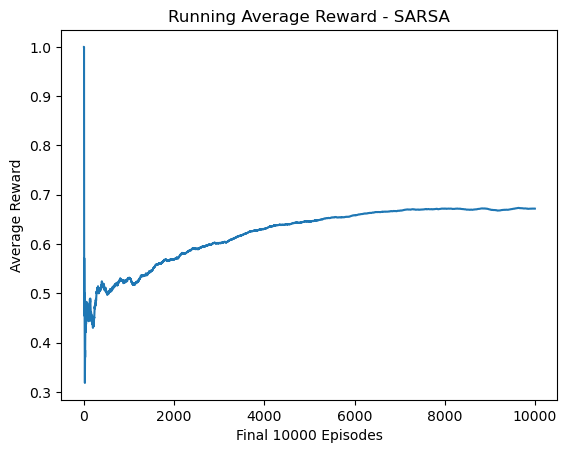

In [79]:
plt.plot(averaged_array)
plt.xlabel('Final 10000 Episodes')
plt.ylabel('Average Reward')
plt.title('Running Average Reward - SARSA')

Text(0.5, 1.0, 'Running Average Number of Moves - SARSA')

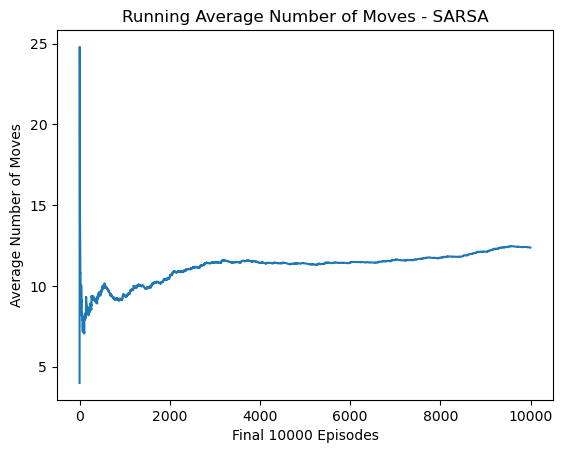

In [82]:
plt.plot(averaged_array2)
plt.xlabel('Final 10000 Episodes')
plt.ylabel('Average Number of Moves')
plt.title('Running Average Number of Moves - SARSA')

In [74]:
def calculate_ema(data, window):
    ema = []
    alpha = 2 / (window + 1)  

    sma = sum(data[:window]) / window
    ema.append(sma)

    for i in range(window, len(data)):
        ema_value = (data[i] - ema[-1]) * alpha + ema[-1]
        ema.append(ema_value)

    return ema

In [75]:
ema_values = calculate_ema(r_save[90000:,], 500)

Text(0.5, 1.0, 'Exponential Moving Average Reward SARSA')

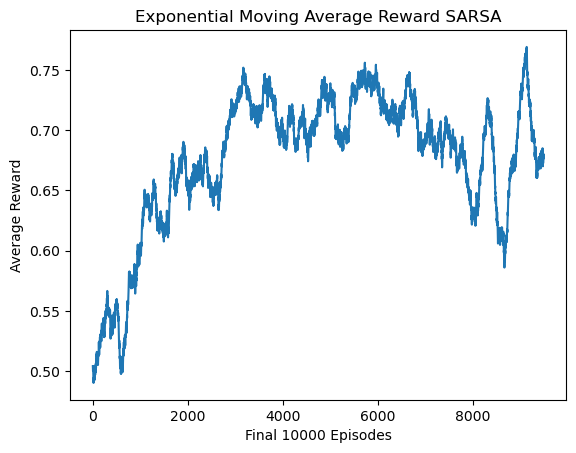

In [81]:
plt.plot(ema_values)
plt.xlabel('Final 10000 Episodes')
plt.ylabel('Average Reward')
plt.title('Exponential Moving Average Reward SARSA')

In [77]:
Sema_values = calculate_ema(n_moves_save[90000:,], 500)

Text(0.5, 1.0, 'Exponential Moving Average Number of Moves SARSA')

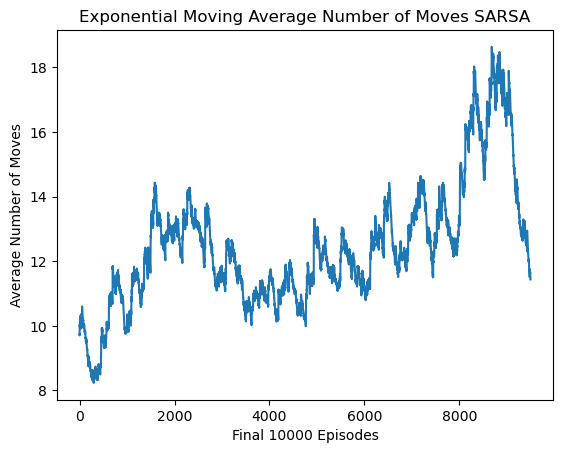

In [80]:
plt.plot(Sema_values)
plt.xlabel('Final 10000 Episodes')
plt.ylabel('Average Number of Moves')
plt.title('Exponential Moving Average Number of Moves SARSA')